# Pystencils 3D Star Stencil Volume Comparison

3D7pt stencil with different block sizes

In [1]:

import sys 
sys.path.append('../pystencils')
sys.path.append('../genpredict')

%load_ext autoreload
%autoreload 1
%aimport pystencils.warpspeed.warpspeed
%aimport predict
%aimport griditeration
%aimport volumes_isl
%aimport pystencils.astnodes
%aimport plot_utils



In [2]:
import cProfile
import re


import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sys
from subprocess import run, PIPE


import pystencils as ps
from pystencils.slicing import add_ghost_layers, make_slice, remove_ghost_layers
from pystencils.warpspeed.warpspeed import PyStencilsWarpSpeedKernel, getFieldExprs, lambdifyExprs, simplifyExprs
from griditeration import *
from volumes_isl import *


from plot_utils import *
from meas_utils import *
from pystencils_stencil_utils import PS3DStencil



import sympy as sp

import pycuda
import pycuda.autoinit
import pycuda.gpuarray as gpuarray
import pycuda.driver as drv

import timeit


In [3]:
size = (640, 512, 512)
SS = PS3DStencil(size, 4)

byte_offset for alignment: 32
byte_offset for alignment: 32


In [4]:
kernel = SS.getStarKernel((32, 4, 4), 1)

print(kernel.ast)


KernelFunction kernel([_data_dst, _data_src])
	Block if:((blockDim.x*blockIdx.x + threadIdx.x + 4 < 636) & (blockDim.y*blockIdx.y + threadIdx.y + 4 < 508) & (blockDim.z*blockIdx.z + threadIdx.z + 4 < 508)) 
		Block ctr_0 ← blockDim.x*blockIdx.x + threadIdx.x + 4
	ctr_1 ← blockDim.y*blockIdx.y + threadIdx.y + 4
	ctr_2 ← blockDim.z*blockIdx.z + threadIdx.z + 4
	_data_dst_10_20 ← _data_dst + 640*ctr_1 + 327680*ctr_2
	_data_src_10_2m1 ← _data_src + 640*ctr_1 + 327680*ctr_2 - 327680
	_data_src_10_20 ← _data_src + 640*ctr_1 + 327680*ctr_2
	_data_src_11_20 ← _data_src + 640*ctr_1 + 327680*ctr_2 + 640
	_data_src_1m1_20 ← _data_src + 640*ctr_1 + 327680*ctr_2 - 640
	_data_src_10_21 ← _data_src + 640*ctr_1 + 327680*ctr_2 + 327680
	_data_dst_10_20[ctr_0] ← cast_func(0.25, double)*_data_src_10_20[ctr_0 + 1] + cast_func(0.25, double)*_data_src_10_20[ctr_0 - 1] + cast_func(0.25, double)*_data_src_10_20[ctr_0] + cast_func(0.25, double)*_data_src_10_21[ctr_0] + cast_func(0.25, double)*_data_src_10_2m1[

In [5]:
predValues = dict()
measValues = dict()
kernelCache = dict()
wsKernelCache = dict()

In [6]:
xticks = []
xtickLabels = []
xtickCounter = 0

print()
print( "                      mem     mem      L2      L2")
print( "                     load   store    load   store       L1")
print()


for r in [4]:
    for xblock in [2, 4, 8, 16, 32, 64, 128]:
        for yblock in [1, 2, 4, 8, 16, 32, 64, 128]:
            for zblock in [1, 2, 4, 8, 16, 32, 64, 128]:
                if xblock*yblock*zblock not in [1024]:
                    continue
                block = (xblock, yblock, zblock)
                key = (r, *block)
                
                if key in kernelCache:
                    kernel = kernelCache[key]
                else:                
                    kernel = SS.getStarKernel(block, r)            
                    kernelCache[key] = kernel
                if key in wsKernelCache:
                    wsKernel = wsKernelCache[key]
                else:
                    wsKernel = PyStencilsWarpSpeedKernel(kernel.ast)     
                    wsKernelCache[key] = wsKernel
                
                runFunc = SS.getRunFunc(kernel)

                grid = tuple( max(1, SS.size[i] // block[i])  for i in range(3))

                print("block:" + str(block))
                predV = getVolumes(wsKernel, block, grid, (r, r, r, *SS.size))
                
                measV = measureMetrics(runFunc, SS.size)
                
                times = [benchKernel(runFunc) for i in range(0, 7)]
                time = times[len(times)//2]
                measV["lups"] = (SS.size[0] - 2*r) * (SS.size[1] - 2*r) * (SS.size[2] - 2*r) / time / 1e6
                
                
                print("r={}  {:12}   {:5.2f}   {:5.2f}   {:5.2f}   {:5.2f}".format(r, str(block), measV["memLoad"], measV["memStore"], measV["L2Load"], measV["L2Store"] ))
                print("            {:5.2f} / {:4.2f}   {:5.2f}   {:5.2f}   {:5.2f}   {:6.1f}".format(predV["memLoad"], predV["memLoadISL"], predV["memStore"], predV["L2Load"], predV["L2Store"], predV["L1cycles"]))
                print(str(measV["lups"] ) + " MLup/s")
                
                key = (r, *block)
                predValues[key] = predV
                measValues[key] = measV            
                
                #print((measV["memStore"] - predV["memStore"]) / (predV["L2Store"] - predV["memStore"]))
                print()


                      mem     mem      L2      L2
                     load   store    load   store       L1

block:(2, 4, 128)
Blocks per SM: 1
Concurrent Grid: (80, 1, 1)
Lups/Block: 1024
(2, 4, 4)
3584
ISL Meta Grid:(4, 126, 3)
Allocated L1 Volume / SM: 228 kB
L1 Load Volume: 432 B / Lup
L1 Warp Load Volume: 112 B / Lup
L1 capacity miss: 38.5 B/Lup
Load Data Volumes (new, old, overlap): 1992  1992  32 kb
Store Data Volumes (mem, L2, evicted): 640 1280 128 kb  
[632, 504, 504]
(316, 126, 8)
1852411360.0
r=4  (2, 4, 128)    19.18   11.54   112.73   20.05
            24.90 / 24.50    8.00   81.00   16.00    416.0
4.6484773035808145 MLup/s

block:(2, 8, 64)
Blocks per SM: 1
Concurrent Grid: (80, 1, 1)
Lups/Block: 1024
(2, 8, 2)
4096
ISL Meta Grid:(4, 63, 7)
Allocated L1 Volume / SM: 168 kB
L1 Load Volume: 432 B / Lup
L1 Warp Load Volume: 128 B / Lup
L1 capacity miss: 21.8 B/Lup
Load Data Volumes (new, old, overlap): 1392  1392  32 kb
Store Data Volumes (mem, L2, evicted): 640 1280 128 

ISL Meta Grid:(1, 126, 15)
Allocated L1 Volume / SM: 68 kB
L1 Load Volume: 224 B / Lup
L1 Warp Load Volume: 96 B / Lup
L1 capacity miss: 0.0 B/Lup
Load Data Volumes (new, old, overlap): 2088  2088  1280 kb
Store Data Volumes (mem, L2, evicted): 640 640 0 kb  
[632, 504, 504]
(79, 126, 16)
1284928576.0
r=4  (8, 4, 32)     10.51    8.00   36.72    8.00
            26.10 / 10.10    8.00   34.00    8.00    104.0
20.664885609486348 MLup/s

block:(8, 8, 16)
Blocks per SM: 1
Concurrent Grid: (79, 1, 1)
Lups/Block: 1024
(8, 4, 1)
3072
ISL Meta Grid:(1, 63, 31)
Allocated L1 Volume / SM: 56 kB
L1 Load Volume: 224 B / Lup
L1 Warp Load Volume: 96 B / Lup
L1 capacity miss: 0.0 B/Lup
Load Data Volumes (new, old, overlap): 1608  1608  640 kb
Store Data Volumes (mem, L2, evicted): 640 640 0 kb  
[632, 504, 504]
(79, 63, 32)
1285138336.0
r=4  (8, 8, 16)     12.32    8.01   29.46    8.00
            20.10 / 12.10    8.00   28.00    8.00    104.0
21.249139144598054 MLup/s

block:(8, 16, 8)
Blocks per SM:

[632, 504, 504]
(20, 126, 63)
1284896320.0
r=4  (32, 4, 8)     16.24    8.00   35.13    8.00
            20.11 / 16.11    8.00   34.00    8.00     52.0
24.03643492452271 MLup/s

block:(32, 8, 4)
Blocks per SM: 1
Concurrent Grid: (19, 4, 1)
Lups/Block: 1024
(32, 1, 1)
4416
ISL Meta Grid:(1, 16, 126)
Allocated L1 Volume / SM: 40 kB
L1 Load Volume: 206 B / Lup
L1 Warp Load Volume: 138 B / Lup
L1 capacity miss: 0.0 B/Lup
Load Data Volumes (new, old, overlap): 2088  2088  160 kb
Store Data Volumes (mem, L2, evicted): 640 640 0 kb  
[632, 504, 504]
(20, 63, 126)
1285375616.0
r=4  (32, 8, 4)     24.25    8.01   34.94    8.00
            26.11 / 24.11    8.00   34.00    8.00     52.0
19.21653588560263 MLup/s

block:(32, 16, 2)
Blocks per SM: 1
Concurrent Grid: (19, 4, 1)
Lups/Block: 1024
(32, 1, 1)
4416
ISL Meta Grid:(1, 8, 252)
Allocated L1 Volume / SM: 52 kB
L1 Load Volume: 206 B / Lup
L1 Warp Load Volume: 138 B / Lup
L1 capacity miss: 0.0 B/Lup
Load Data Volumes (new, old, overlap): 3288  3

In [7]:

for key in predValues.keys():
  
    r, xblock, yblock, zblock = key
    
    block = (xblock, yblock, zblock)

    results = predValues[key]


    threadsPerBlock = xblock*yblock*zblock
    concurrentBlocks = min(32, 1024 // threadsPerBlock) * 80
    vMemComplete = results["memLoadISL"] * concurrentBlocks * threadsPerBlock
    sizeL2 = 6 * 1024 * 1024

    vMemStore = results["memStore"] * concurrentBlocks * threadsPerBlock
    vL2Store = results["L2Store"] * concurrentBlocks * threadsPerBlock
    vL2Load = results["L2Load"] * concurrentBlocks * threadsPerBlock

    vMem = vMemComplete



    vStoreEvicted = 0
    if vMemStore > 0:
        effectiveL2 = sizeL2*0.3
        effectiveL2 *= vMemStore / (vMemStore + vMemComplete)
        effectiveL2 *= vMemComplete / (vMemComplete + vMemStore)
        vStoreEvicted = (vL2Store - vMemStore) * max(0, (vMemStore - effectiveL2)) / vMemStore

    results["memStoreExt2"] = ( vMemStore + vStoreEvicted) / concurrentBlocks / threadsPerBlock

    
    vMemEvicted = 0
    if vMemStore > 0:
        vMemEvicted += vStoreEvicted #(vL2Store - vMemStore) * max(0, (vMemStore - sizeL2 * (vMemStore / (vMemStore + vMemComplete))  * min( 1,  (block[0] * concurrentBlocks) / 2000)  )) / vMemStore           
        #vMemEvicted += (vL2Load - vMemComplete)
    #if vMemComplete > 0:
    #    effectiveL2 = sizeL2
    #    effectiveL2 *= vMemComplete / (vMemComplete + vMemStore)
    #    effectiveL2 *= max(0.2, min( 1,  (block[0] * concurrentBlocks) / domain_size[0]))
    #    vMemEvicted += (vL2Load - vMemComplete) * 0.1*max(0, (vMemComplete / effectiveL2))


    results["memLoadISLext2"] = (vMem + vMemEvicted) / concurrentBlocks / threadsPerBlock
    #print(results["memLoadISLext"])

    results["memTotal"] = results["memLoadISLext"] + results["memStoreExt"]
    #print(vL2Load / 80 / 1024)
    #print( ((measValues[key]["memLoad"] * threadsPerBlock*concurrentBlocks) - vMemComplete) / (vL2Load - vMemComplete) )

No handles with labels found to put in legend.


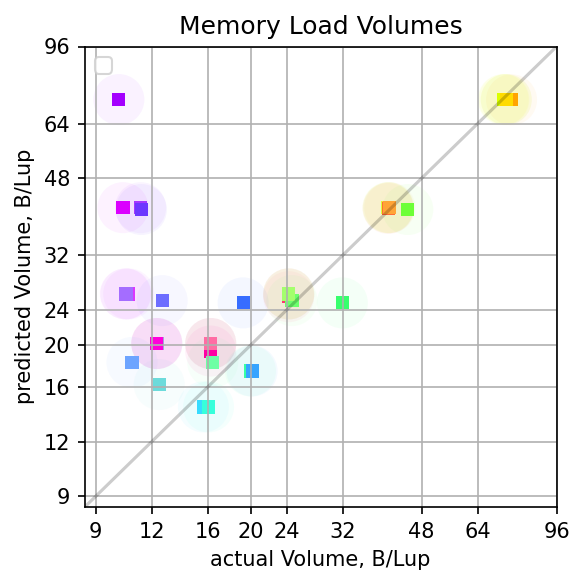

No handles with labels found to put in legend.


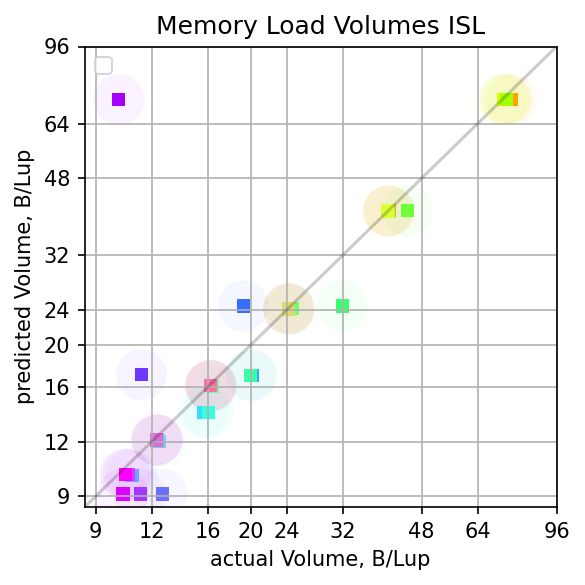

No handles with labels found to put in legend.


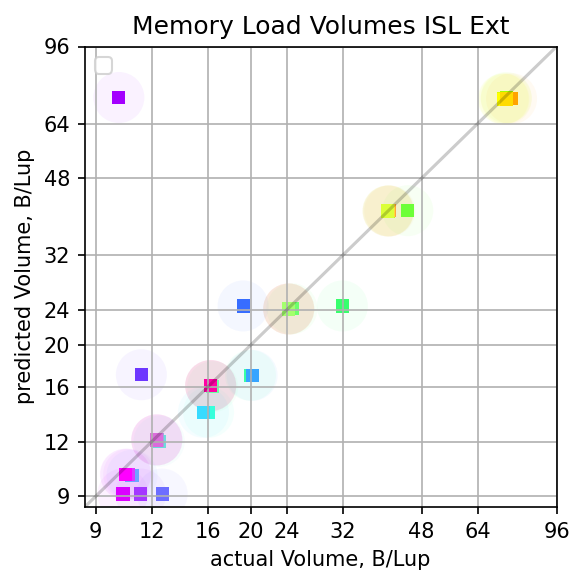

No handles with labels found to put in legend.


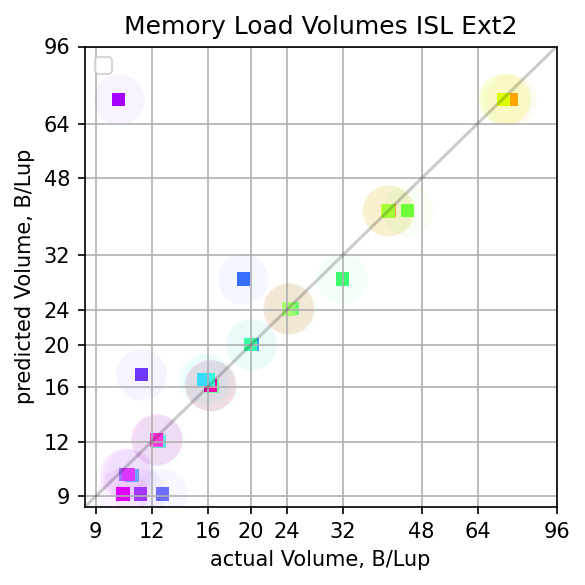

In [123]:
volumeScatterPlot({key: v["memLoad"] for key, v in measValues.items()}, {key: v["memLoad"] for key, v in predValues.items()}, "Memory Load Volumes", (8.5, 96))
volumeScatterPlot({key: v["memLoad"] for key, v in measValues.items()}, {key: v["memLoadISL"] for key, v in predValues.items()}, "Memory Load Volumes ISL", (8.5, 96))
volumeScatterPlot({key: v["memLoad"] for key, v in measValues.items()}, {key: v["memLoadISLext"] for key, v in predValues.items()}, "Memory Load Volumes ISL Ext", (8.5, 96))
volumeScatterPlot({key: v["memLoad"] for key, v in measValues.items()}, {key: v["memLoadISLext2"] for key, v in predValues.items()}, "Memory Load Volumes ISL Ext2", (8.5, 96))

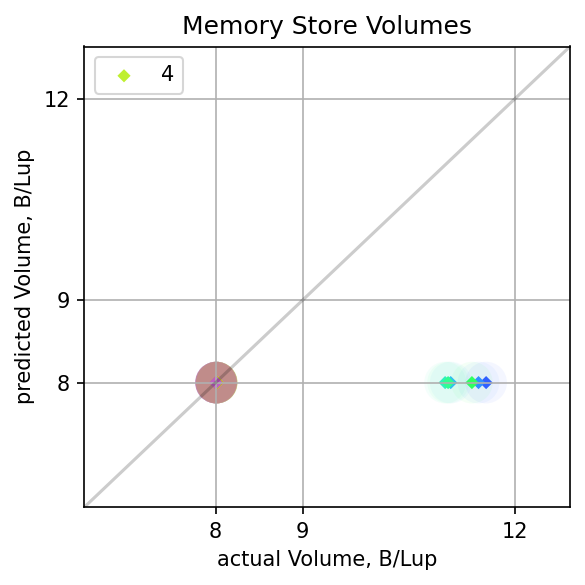

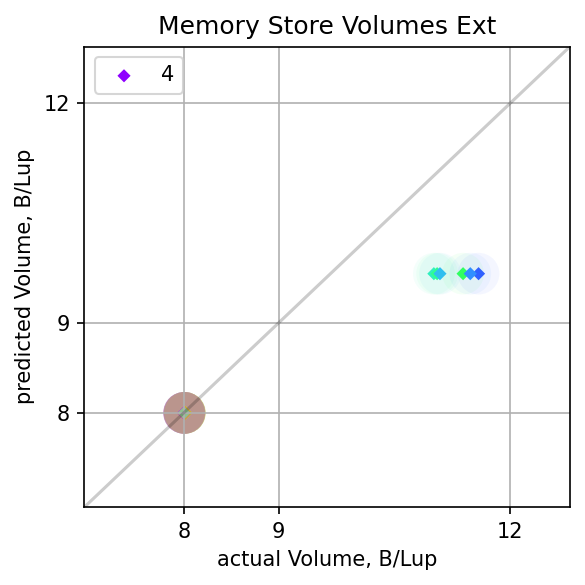

In [9]:
volumeScatterPlot({key: v["memStore"] for key, v in measValues.items()}, {key: v["memStore"] for key, v in predValues.items()}, "Memory Store Volumes")
volumeScatterPlot({key: v["memStore"] for key, v in measValues.items()}, {key: v["memStoreExt"] for key, v in predValues.items()}, "Memory Store Volumes Ext")

In [62]:
#volumeScatterPlot({key: v["L2Load"] for key, v in measValues.items()}, {key: v["L2Load"] for key, v in predValues.items()}, "L2 Load Volumes", (24, 180) )
#volumeScatterPlot({key: v["L2Load"] for key, v in measValues.items()}, {key: v["L2LoadExt"] for key, v in predValues.items()}, "L2 Load Volumes Ext", (24, 180))
#volumeScatterPlot({key: v["L2Store"] for key, v in measValues.items()}, {key: v["L2Store"] for key, v in predValues.items()}, "L2 Store Volumes")


print(sorted([ (v["memLoad"], key)  for key, v in measValues.items()]))


[(10.132617580553084, (4, 8, 1, 128)), (10.346982628025424, (4, 16, 1, 64)), (10.47559567662039, (4, 32, 1, 32)), (10.506963779417065, (4, 8, 4, 32)), (10.659419440537585, (4, 16, 2, 32)), (10.838300627330163, (4, 4, 8, 32)), (11.33055507716448, (4, 8, 2, 64)), (11.374246135397431, (4, 4, 2, 128)), (12.30282832776805, (4, 64, 1, 16)), (12.31098529425835, (4, 32, 2, 16)), (12.31271348201728, (4, 16, 4, 16)), (12.322458308217803, (4, 8, 8, 16)), (12.465786267624724, (4, 4, 16, 16)), (12.655226342764015, (4, 4, 4, 64)), (15.642682131455489, (4, 2, 16, 32)), (16.06297859040475, (4, 2, 32, 16)), (16.23249646787923, (4, 128, 1, 8)), (16.235495182601873, (4, 32, 4, 8)), (16.238003945131734, (4, 64, 2, 8)), (16.242487466153833, (4, 16, 8, 8)), (16.242671048728916, (4, 8, 16, 8)), (16.40866238666118, (4, 4, 32, 8)), (19.18137021569059, (4, 2, 4, 128)), (19.923791305082744, (4, 2, 64, 8)), (20.089388767696484, (4, 2, 8, 64)), (24.2344893653664, (4, 128, 2, 4)), (24.23523844605822, (4, 16, 16, 4)

In [11]:
def differenceScatterPlot( measValues, predValues, measKey, predKey1, predKey2, title, lims = None ):  
    
    fig, ax = plt.subplots()
    fig.set_figwidth(4)
    fig.set_figheight(4)
    fig.set_dpi(150)
       
    keys = differences = [key for key, v in predValues.items() if abs(v[predKey1] - v[predKey2]) / v[predKey1] > 0.1]
    random.shuffle(keys)
    
    measValues = [measValues[key][measKey] for key in keys]
    predValues1 = [predValues[key][predKey1] for key in keys]
    predValues2 = [predValues[key][predKey2] for key in keys]
    
    colors = [tuple(math.log2(bc) for bc in b[1:]) for b in keys]    
    colors = [tuple([min(1.0, color[i] / math.log2(256) * 1.5)
                        for i in range(len(colors[0]))
                    ] + [0] * (3 - len(colors[0])))
            for color in colors]

    #ax.scatter(
    #    measValues, predValues2,
    #    s=[40] * len(colors), c=colors,
    #    marker="P", alpha=1,
    #    edgecolors="none",label=str(r),
    #)
    ax.scatter(
        measValues,      predValues1,
        s=[30] * len(colors),color="gray",
        marker="o",alpha=1,
        edgecolors="none",label=str(r),
    )
    #ax.vlines(measValues, predValues1, predValues2, color="grey", linewidth=0.5, linestyle="solid")

    for v in zip(measValues, predValues1, predValues2):
        ax.arrow( v[0], v[1], 0, v[2] - v[1], linewidth=0.5, head_width=0.05*v[0], fill=False, head_length=0.05*v[2], length_includes_head=True)

    ax.set_xscale("log", base=1.5)
    ax.set_yscale("log", base=1.5)
    
     
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    ax.set_xticks(
        [0.1, 1.0, 2, 4, 8, 9, 12, 16, 20, 24, 32, 48, 64, 96, 128, 192, 256, 384, 512]
    )
    ax.set_yticks(
        [0.1, 1.0, 2, 4, 8, 9, 12, 16, 20, 24, 32, 48, 64, 96, 128, 192, 256, 384, 512]
    )
    formatter = matplotlib.ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x))
    ax.get_xaxis().set_major_formatter(formatter)
    ax.get_yaxis().set_major_formatter(formatter)

   

    if not lims is None:
        ax.set_xlim(lims)
        ax.set_ylim(lims)
    else:
        lim = (min(ylim[0], xlim[0]), max(ylim[1], xlim[1]))
        ax.set_xlim(
            (max(min(lim[0] * 0.9, lim[0] - 0.1), 0.2), max(1, lim[1] * 1.1, lim[1] + 0.1))
        )
        ax.set_ylim(
            (max(min(lim[0] * 0.9, lim[0] - 0.1), 0.2), max(1, lim[1] * 1.1, lim[1] + 0.1))
        )

    ax.set_xlabel("actual Volume, B/Lup")
    ax.set_ylabel("predicted Volume, B/Lup")
    ax.set_title(title)

        
    fig.tight_layout()
    ax.grid()

    plt.savefig( "./autoplots/diff_" + title + ".svg")
    plt.show()


    



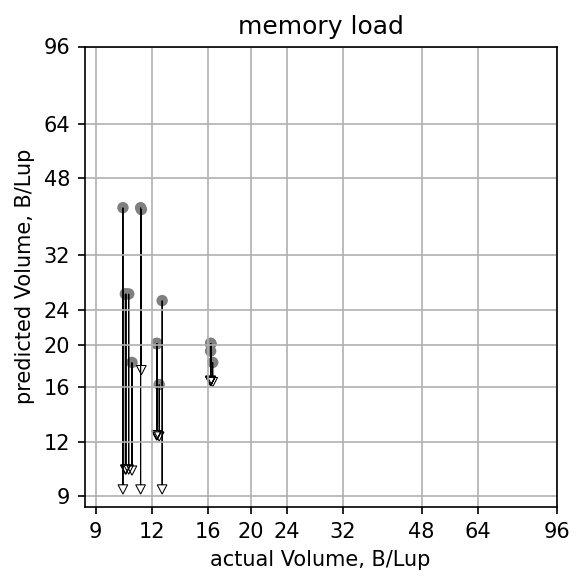

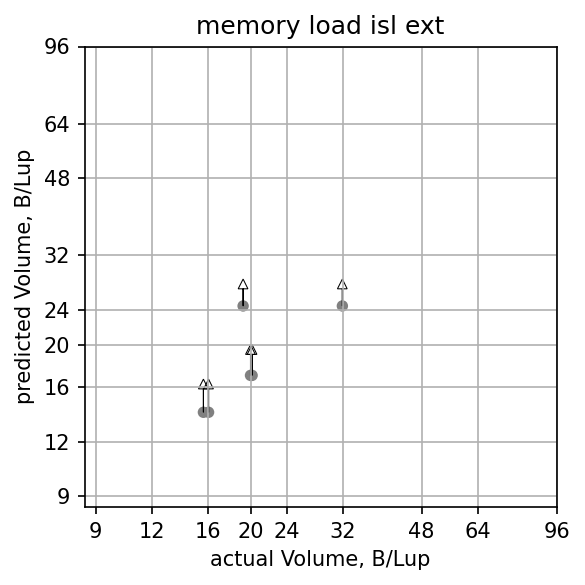

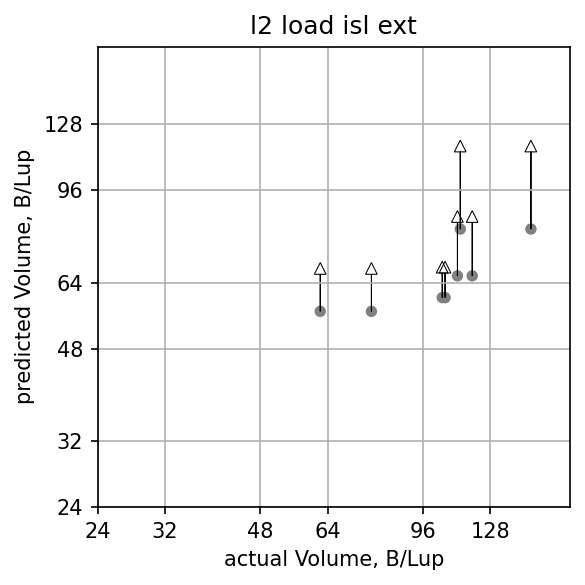

In [34]:
differenceScatterPlot(measValues, predValues, "memLoad", "memLoad", "memLoadISLext", "memory load", (8.5,96))    
differenceScatterPlot(measValues, predValues, "memLoad", "memLoadISL", "memLoadISLext2", "memory load isl ext" ,(8.5,96) )    
differenceScatterPlot(measValues, predValues, "L2Load", "L2Load", "L2LoadExt", "l2 load isl ext" ,(24,180) )    


[(33.19, (32, 4, 8)), (39.79, (16, 4, 16)), (39.79, (32, 2, 16)), (44.19, (16, 2, 32))]
[(25.86, (16, 2, 32)), (26.02, (16, 4, 16)), (26.36, (32, 1, 32)), (26.96, (32, 2, 16))]
{(4, 2, 4, 128): 3, (4, 2, 8, 64): 3, (4, 2, 16, 32): 3, (4, 2, 32, 16): 3, (4, 2, 64, 8): 3, (4, 2, 128, 4): 3, (4, 4, 2, 128): 3, (4, 4, 4, 64): 3, (4, 4, 8, 32): 3, (4, 4, 16, 16): 3, (4, 4, 32, 8): 3, (4, 4, 64, 4): 3, (4, 4, 128, 2): 3, (4, 8, 1, 128): 1, (4, 8, 2, 64): 3, (4, 8, 4, 32): 3, (4, 8, 8, 16): 3, (4, 8, 16, 8): 3, (4, 8, 32, 4): 1, (4, 8, 64, 2): 1, (4, 8, 128, 1): 1, (4, 16, 1, 64): 2, (4, 16, 2, 32): 1, (4, 16, 4, 16): 1, (4, 16, 8, 8): 1, (4, 16, 16, 4): 1, (4, 16, 32, 2): 1, (4, 16, 64, 1): 1, (4, 32, 1, 32): 2, (4, 32, 2, 16): 1, (4, 32, 4, 8): 1, (4, 32, 8, 4): 1, (4, 32, 16, 2): 1, (4, 32, 32, 1): 1, (4, 64, 1, 16): 2, (4, 64, 2, 8): 1, (4, 64, 4, 4): 1, (4, 64, 8, 2): 1, (4, 64, 16, 1): 1, (4, 128, 1, 8): 2, (4, 128, 2, 4): 1, (4, 128, 4, 2): 1, (4, 128, 8, 1): 1}


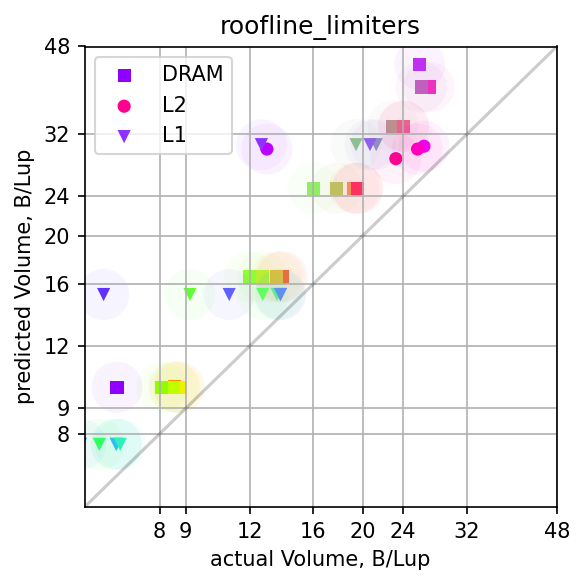

No handles with labels found to put in legend.


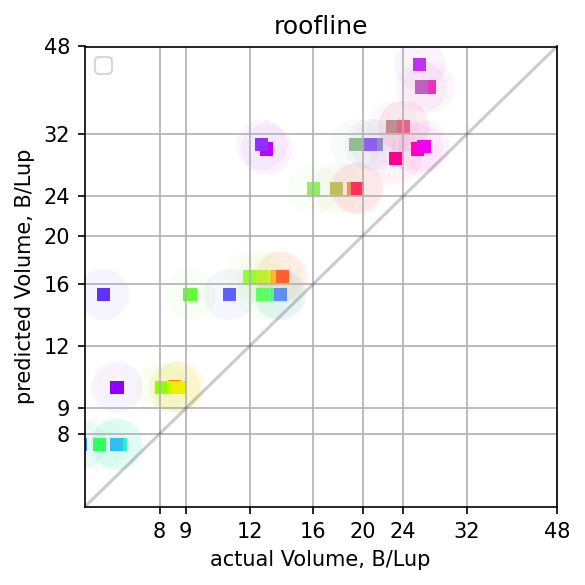

No handles with labels found to put in legend.


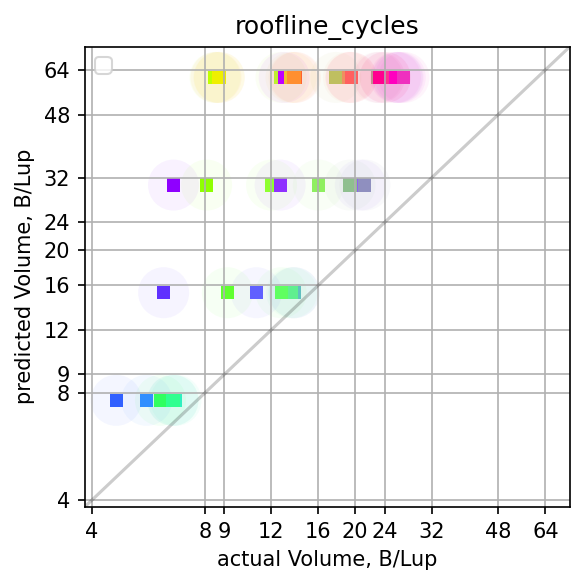

No handles with labels found to put in legend.


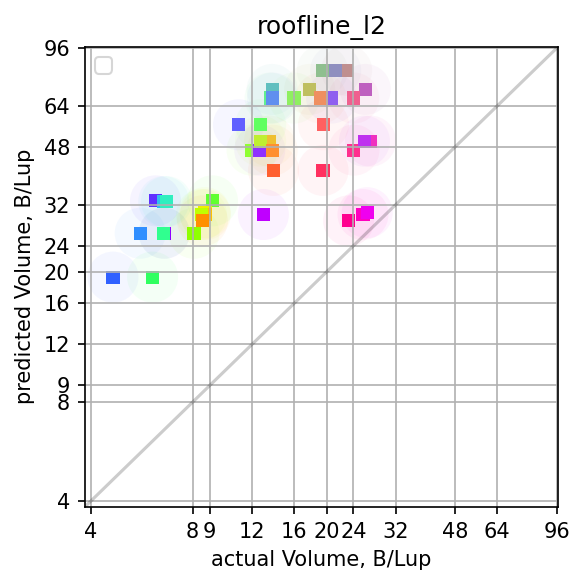

No handles with labels found to put in legend.


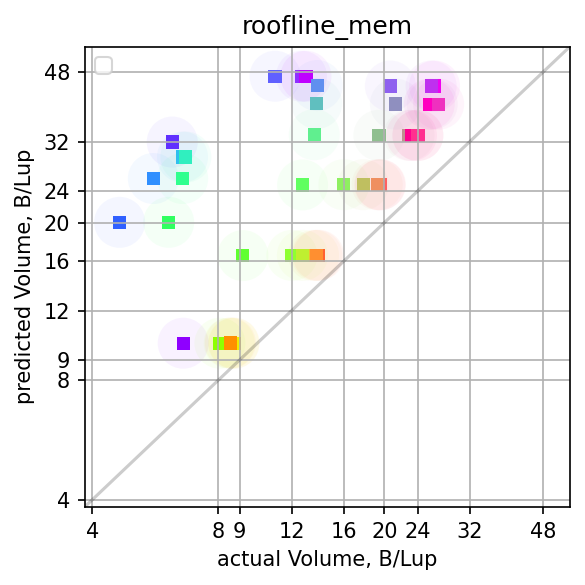

In [114]:
for key in measValues.keys():

    memBalance = predValues[key]["memLoadISLext2"] + predValues[key]["memStoreExt2"]
    l2Balance = predValues[key]["L2LoadExt"] #+ predValues[key]["L2Store"]
    
    predValues[key]["lupsMem"] = 800 / memBalance
    predValues[key]["lupsL2"] = 2300 / l2Balance
    predValues[key]["lupsL1"] = 80 * 1.38 * 32 / (predValues[key]["L1cycles"] * 18 / 17) * 0.95
    predValues[key]["lups"] = min(predValues[key]["lupsMem"], predValues[key]["lupsL2"], predValues[key]["lupsL1"] )

predLups = sorted([(round( predValues[key]["lups"], 2) , key[1:]) for key in predValues.keys()]  )
measLups = sorted([(round(measValues[key]["lups"], 2) , key[1:]) for key in measValues.keys()]  )

print(predLups[-4:])
print(measLups[-4:])



limiters = { key : 1 if predValues[key]["lupsMem"] == predValues[key]["lups"] else (2 if predValues[key]["lupsL2"] == predValues[key]["lups"] else 3)  for key in measValues.keys() }

print(limiters)


volumeScatterPlot({ (limiters[key], *key[1:]) : v["lups"] for key, v in measValues.items()},
                  { (limiters[key], *key[1:]) : v["lups"] for key, v in predValues.items()}, "roofline_limiters", (5.7, 48))



volumeScatterPlot({key: v["lups"] for key, v in measValues.items()}, {key: v["lups"] for key, v in predValues.items()}, "roofline", (5.7,48))
volumeScatterPlot({key: v["lups"] for key, v in measValues.items()}, {key: v["lupsL1"] for key, v in predValues.items()}, "roofline_cycles")
volumeScatterPlot({key: v["lups"] for key, v in measValues.items()}, {key: v["lupsL2"] for key, v in predValues.items()}, "roofline_l2")
volumeScatterPlot({key: v["lups"] for key, v in measValues.items()}, {key: v["lupsMem"] for key, v in predValues.items()}, "roofline_mem")


